# 101 of A/B testing

Below is a self-contained Python "lecture notebook" (in markdown + code) illustrating the five Anthropic Stats 101 recommendations for robust A/B testing with LLMs. We link each recommendation to the overarching question:

"Is Model B really better than Model A on our benchmark, or is it just luck?"

We simulate a scenario:
- Model A and Model B are tested on questions from a "question universe."
- Model B is slightly stronger, but we want to prove this difference rigorously.

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

sns.set(style="whitegrid", context="talk")
np.random.seed(42)  # Reproducibility

# Recommendation 1: Use the Central Limit Theorem

Why do we need CLT?

When we test an LLM on $n$ questions, each question's correctness $(X_i)$ is random. The overall accuracy is

$$
\bar{X} = \frac{1}{n} \sum_{i=1}^{n} X_i.
$$

By the Central Limit Theorem, if each $X_i$ is an iid draw from some distribution with mean $\mu$ and variance $\sigma^2$, then for large $n$

$$
\bar{X} \approx \mathcal{N}\bigl(\mu,\; \frac{\sigma^2}{n}\bigr).
$$

This justifies a standard error

$$
\text{SEM} = \sqrt{\frac{\sigma^2}{n}},
$$

and a 95% confidence interval

$$
\bar{X} \pm 1.96 \times \text{SEM}.
$$

Concrete Example:  
We simulate many "evals" with 200 questions each. Model A has a true success probability of 0.55. We collect the sample mean accuracy across simulations, which forms an approximately bell-shaped distribution. Reporting the SEM alongside the mean reveals how much "luck" might be involved in a single evaluation.

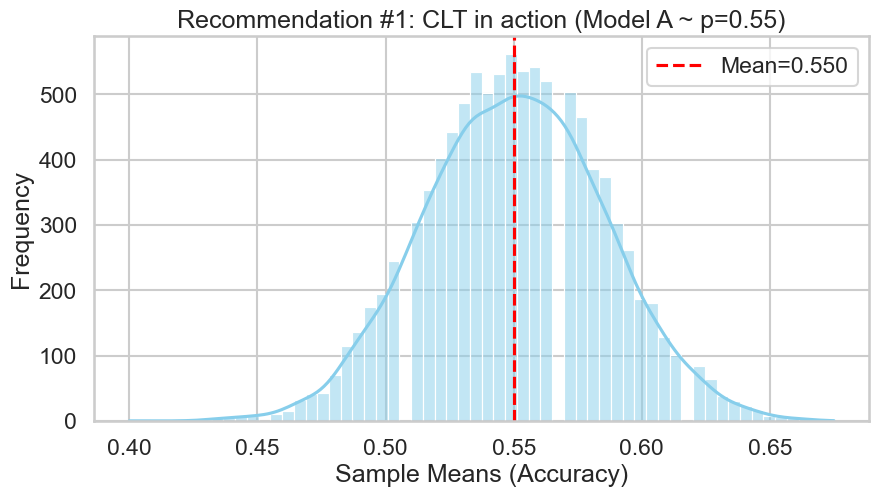

=== Recommendation #1: CLT Demo ===
Empirical SE from simulations: 0.0352
Theoretical SE (sqrt(p(1-p)/n)): 0.0352
Approx. 95% CI of the mean accuracy: [0.481, 0.619]



In [8]:
###############################################################################
# 1. CENTRAL LIMIT THEOREM DEMO
###############################################################################

def simulate_clt(num_questions=200, true_p=0.55, num_sims=10000):
    """
    Generate num_sims samples, each with num_questions from Bernoulli(true_p).
    Return an array of sample means.
    """
    sample_means = []
    for _ in range(num_sims):
        data = np.random.binomial(n=1, p=true_p, size=num_questions)
        sample_means.append(data.mean())
    return np.array(sample_means)

# --- 1A. Generate a distribution of sample means ---
means_clt = simulate_clt(num_questions=200, true_p=0.55, num_sims=10000)

# --- 1B. Compare distribution of sample means with a normal approximation ---
plt.figure(figsize=(10,5))
sns.histplot(means_clt, kde=True, color="skyblue")
plt.axvline(means_clt.mean(), color="red", linestyle="--", label=f"Mean={means_clt.mean():.3f}")
plt.title("Recommendation #1: CLT in action (Model A ~ p=0.55)")
plt.xlabel("Sample Means (Accuracy)")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# --- 1C. Calculate empirical vs. theoretical standard error ---
empirical_se = np.std(means_clt, ddof=1)
theoretical_se = np.sqrt(0.55 * 0.45 / 200)

print("=== Recommendation #1: CLT Demo ===")
print(f"Empirical SE from simulations: {empirical_se:.4f}")
print(f"Theoretical SE (sqrt(p(1-p)/n)): {theoretical_se:.4f}")

ci_lower = means_clt.mean() - 1.96 * empirical_se
ci_upper = means_clt.mean() + 1.96 * empirical_se
print(f"Approx. 95% CI of the mean accuracy: [{ci_lower:.3f}, {ci_upper:.3f}]\n")


# Recommendation 2: Cluster Standard Errors

Why do we need clustering?

Some evals bundle questions into clusters (for example, multiple questions about one reading passage). Such questions are not independent. Ignoring the correlation usually underestimates the true variance. A one-way cluster-robust formula for the variance of the mean is

$$
\widehat{\text{Var}}(\bar{X}) = \frac{1}{N^2} \sum_{g=1}^{G} n_g^2 \,\widehat{\sigma}^2(\bar{X}_g),
$$

where $g$ indexes each cluster, $G$ is the total number of clusters, $n_g$ is the number of observations in cluster $g$, and $\bar{X}_g$ is the cluster's mean.

Concrete Example:  
We simulate 10 passages, each with 20 questions, for 200 total. Each passage has its own random difficulty offset. The naive standard error is smaller, whereas the clustered one is larger and more realistic. Clustering helps avoid false positives.


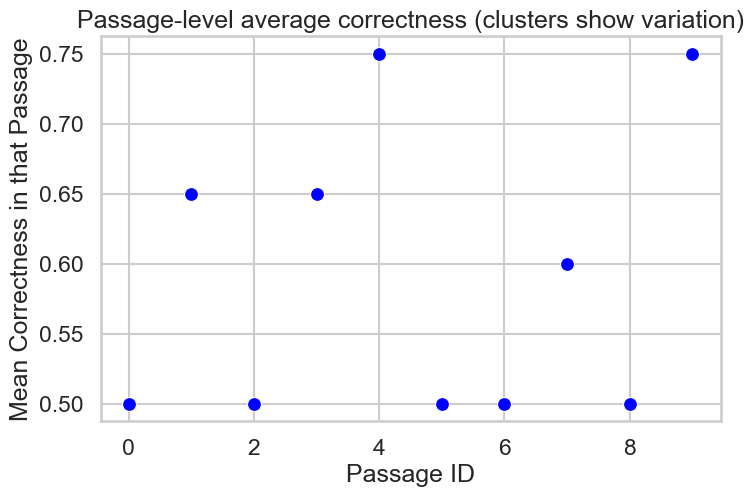

=== Recommendation #2: Clustered Standard Errors ===
Naive Mean Accuracy:           0.590
Naive SE (no clustering):      0.0349
Clustered SE (one-way):        0.6633
Note how the clustered SE is often larger.



In [9]:
###############################################################################
# 2. CLUSTERED STANDARD ERRORS DEMO
###############################################################################

def simulate_cluster_data(num_passages=10, q_per_passage=20, true_p=0.55):
    """
    For each passage, draw a random difficulty offset in [-0.1, 0.1].
    Then draw correctness for each question in that passage.
    Returns a DataFrame with passage_id and correctness.
    """
    data_records = []
    for passage_id in range(num_passages):
        # random offset
        passage_offset = np.random.uniform(-0.1, 0.1)
        for _ in range(q_per_passage):
            p = np.clip(true_p + passage_offset, 0, 1)
            correct = np.random.binomial(1, p)
            data_records.append((passage_id, correct))
    df = pd.DataFrame(data_records, columns=["passage_id","correct"])
    return df

df_cluster = simulate_cluster_data(num_passages=10, q_per_passage=20, true_p=0.55)

# -- 2A. Plot each passage's mean correctness to visualize cluster differences --
passage_means = df_cluster.groupby("passage_id")["correct"].mean()
plt.figure(figsize=(8,5))
sns.scatterplot(x=passage_means.index, y=passage_means.values, s=100, color="blue")
plt.title("Passage-level average correctness (clusters show variation)")
plt.xlabel("Passage ID")
plt.ylabel("Mean Correctness in that Passage")
plt.show()

# -- 2B. Compute naive standard error (ignoring clustering) --
naive_mean = df_cluster["correct"].mean()
naive_se   = df_cluster["correct"].std(ddof=1) / np.sqrt(len(df_cluster))

# -- 2C. Compute cluster-robust standard error (one-way) --
cluster_means = df_cluster.groupby("passage_id")["correct"].mean()
cluster_sizes = df_cluster.groupby("passage_id")["correct"].count()

n_clusters = len(cluster_means)
n_total = len(df_cluster)

# variance of cluster means
var_cluster_means = cluster_means.var(ddof=1)
avg_size = cluster_sizes.mean()

# simplified one-way cluster formula
clustered_se = np.sqrt(var_cluster_means * (avg_size**2) / n_clusters)

print("=== Recommendation #2: Clustered Standard Errors ===")
print(f"Naive Mean Accuracy:           {naive_mean:.3f}")
print(f"Naive SE (no clustering):      {naive_se:.4f}")
print(f"Clustered SE (one-way):        {clustered_se:.4f}")
print("Note how the clustered SE is often larger.\n")


# Recommendation 3: Reduce Variance Within Questions

Why do we need to reduce variance?

When an LLM uses a non-deterministic decoding strategy, it might give different answers to the same question if prompted multiple times. A single shot yields a 0 or 1 score, which is high variance. By sampling $m$ times per question and averaging, the per-question variance shrinks by a factor of $m.$ Formally,

$$
\text{Var}\bigl(\overline{X}_{\text{q}}\bigr) = \frac{\sigma^2}{m}.
$$

Concrete Example:  
We simulate Model A on 200 questions with true probability 0.60. In single-shot mode, each question produces a single 0/1. In multi-shot mode (5 attempts per question), each final question-level score is the mean of 5 draws. The multi-shot approach has substantially lower variance and a smaller final standard error.

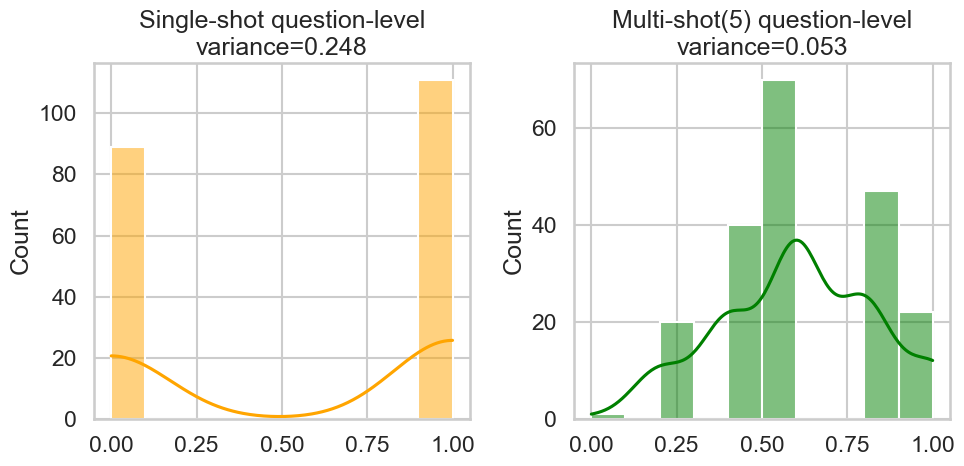

=== Recommendation #3: Reduce Variance Within Questions ===
Single-sample -> mean=0.555, question-level var=0.2482, SE=0.0352
Multi-sample(5) -> mean=0.608, question-level var=0.0530, SE=0.0163



In [14]:
###############################################################################
# 3. REDUCE VARIANCE WITH MULTIPLE SAMPLES
###############################################################################

def simulate_cot_resamples(num_questions=200, true_p=0.60, resamples=5):
    """
    For each question, sample correctness 'resamples' times from Bernoulli(true_p).
    Then average those correctness values to get the final question-level score.
    """
    question_scores = []
    for _ in range(num_questions):
        draws = np.random.binomial(n=1, p=true_p, size=resamples)
        avg_score = draws.mean()
        question_scores.append(avg_score)
    return np.array(question_scores)

# --- 3A. Single-sample vs multi-sample for Model A ---
numQ = 200
pA = 0.60
single_shot = np.random.binomial(n=1, p=pA, size=numQ)   # question-level 0/1
multi_shot  = simulate_cot_resamples(numQ, pA, resamples=5)  # question-level average

single_mean = single_shot.mean()
single_var  = single_shot.var(ddof=1)
multi_mean  = multi_shot.mean()
multi_var   = multi_shot.var(ddof=1)

# compute SE for each approach
single_se = np.sqrt(single_var / numQ)
multi_se  = np.sqrt(multi_var  / numQ)

plt.figure(figsize=(10,5))

# Visualization of question-level distributions
plt.subplot(1,2,1)
sns.histplot(single_shot, color="orange", kde=True, binwidth=0.1)
plt.title(f"Single-shot question-level\nvariance={single_var:.3f}")

plt.subplot(1,2,2)
sns.histplot(multi_shot, color="green", kde=True, binwidth=0.1)
plt.title(f"Multi-shot(5) question-level\nvariance={multi_var:.3f}")

plt.tight_layout()
plt.show()

print("=== Recommendation #3: Reduce Variance Within Questions ===")
print(f"Single-sample -> mean={single_mean:.3f}, question-level var={single_var:.4f}, SE={single_se:.4f}")
print(f"Multi-sample(5) -> mean={multi_mean:.3f}, question-level var={multi_var:.4f}, SE={multi_se:.4f}\n")


# Recommendation 4: Analyze Paired Differences

Why do we need paired differences?

When both models see the same questions, each question has its own difficulty. Let

$$
D_i = X_{B,i} - X_{A,i}.
$$

Then

$$
\bar{D} = \frac{1}{n}\sum_{i=1}^n D_i.
$$

This paired approach removes the shared difficulty component. If Model A and Model B answers are positively correlated, the variance of $D_i$ is smaller than treating the data as two independent samples. Hence, we get a more precise standard error for the difference.

Concrete Example:  
We simulate 300 questions for Model A (pA=0.55) and Model B (pB=0.60), introducing correlation in question difficulty. An unpaired two-sample approach yields a certain standard error for (meanB - meanA). A paired approach yields the same difference in means but a smaller standard error because question difficulty cancels out.

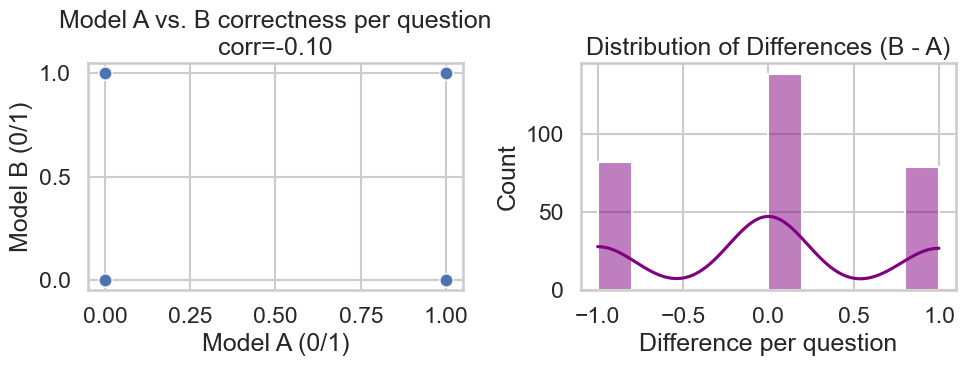

=== Recommendation #4: Paired Differences ===
Unpaired difference:  -0.010, SE=0.0404
Paired difference:    -0.010, SE=0.0424
Correlation(A,B):     -0.098
Paired approach typically yields a lower SE (variance reduction).



In [13]:
###############################################################################
# 4. PAIRED DIFFERENCES DEMO
###############################################################################

def simulate_two_models(num_questions=300, pA=0.55, pB=0.60):
    """
    Return question-level correctness for both models.
    Introduce correlation by adding a random 'difficulty' offset
    that affects both models similarly.
    """
    question_difficulty = np.random.uniform(-0.05, 0.05, size=num_questions)
    modelA_scores = []
    modelB_scores = []
    for i in range(num_questions):
        pA_eff = np.clip(pA + question_difficulty[i], 0, 1)
        pB_eff = np.clip(pB + question_difficulty[i], 0, 1)
        modelA_scores.append(np.random.binomial(1, pA_eff))
        modelB_scores.append(np.random.binomial(1, pB_eff))
    
    df = pd.DataFrame({
        "q_id": range(num_questions),
        "modelA": modelA_scores,
        "modelB": modelB_scores
    })
    return df

df_models = simulate_two_models(num_questions=300, pA=0.55, pB=0.60)

# -- 4A. Unpaired difference (two-sample approach) --
meanA = df_models["modelA"].mean()
meanB = df_models["modelB"].mean()
diff_unpaired = meanB - meanA

varA = df_models["modelA"].var(ddof=1)
varB = df_models["modelB"].var(ddof=1)
n = len(df_models)

# Standard error for unpaired difference
se_unpaired = np.sqrt(varA/n + varB/n)

# -- 4B. Paired difference (D_i = modelB - modelA) --
df_models["diff"] = df_models["modelB"] - df_models["modelA"]
diff_paired = df_models["diff"].mean()
var_diff = df_models["diff"].var(ddof=1)

# Standard error for paired difference
se_paired = np.sqrt(var_diff / n)

corr = np.corrcoef(df_models["modelA"], df_models["modelB"])[0,1]

# Visualize the difference distribution
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.scatterplot(x=df_models["modelA"], y=df_models["modelB"], alpha=0.5)
plt.title(f"Model A vs. B correctness per question\ncorr={corr:.2f}")
plt.xlabel("Model A (0/1)")
plt.ylabel("Model B (0/1)")

plt.subplot(1,2,2)
sns.histplot(df_models["diff"], kde=True, color="purple")
plt.title("Distribution of Differences (B - A)")
plt.xlabel("Difference per question")
plt.tight_layout()
plt.show()

print("=== Recommendation #4: Paired Differences ===")
print(f"Unpaired difference:  {diff_unpaired:.3f}, SE={se_unpaired:.4f}")
print(f"Paired difference:    {diff_paired:.3f}, SE={se_paired:.4f}")
print(f"Correlation(A,B):     {corr:.3f}")
print("Paired approach typically yields a lower SE (variance reduction).\n")


# Recommendation 5: Use Power Analysis

Why do we need power analysis?

Power is the probability of detecting a true difference if it really exists. When the sample size is small, confidence intervals are wide, and we may fail to reject the null hypothesis. If we want to detect a difference of magnitude $\delta$ at significance level $\alpha,$ we need enough questions $n$ to achieve a suitable power (often at least 0.80).

Concrete Example:  
We aim to detect a 3% difference (0.55 vs. 0.58). We vary the number of questions from 50 up to 800, run many simulations, and see how often a paired t-test declares significance. With only 50 questions, power is typically low. As $n$ increases, power approaches 1, meaning we reliably detect the difference.

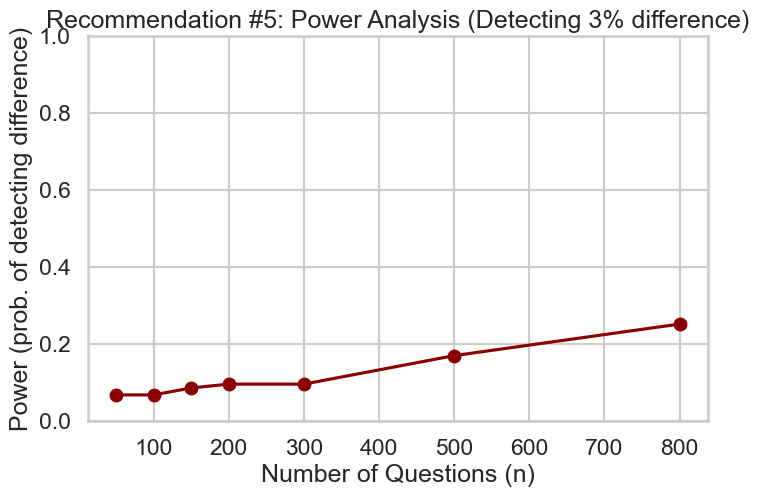

=== Recommendation #5: Power Analysis ===
   num_questions  power
0             50  0.068
1            100  0.068
2            150  0.086
3            200  0.096
4            300  0.096
5            500  0.170
6            800  0.252

If power is below ~0.80, we risk not detecting real differences. We might need more questions or repeated sampling per question.



In [12]:
###############################################################################
# 5. POWER ANALYSIS DEMO
###############################################################################

def simulate_power(num_questions_list, pA=0.55, pB=0.58, num_sims=500, alpha=0.05):
    """
    For each n in num_questions_list, run 'num_sims' Monte Carlo simulations.
    Each simulation: generate data for both models, run a paired t-test.
    Return a DataFrame with power (fraction that p-value < alpha).
    """
    results = []
    for n in num_questions_list:
        sig_count = 0
        for _ in range(num_sims):
            df = simulate_two_models(num_questions=n, pA=pA, pB=pB)
            # Paired t-test
            t_stat, p_val = stats.ttest_rel(df["modelB"], df["modelA"])
            if p_val < alpha:
                sig_count += 1
        power = sig_count / num_sims
        results.append((n, power))
    
    return pd.DataFrame(results, columns=["num_questions","power"])

num_questions_list = [50, 100, 150, 200, 300, 500, 800]
df_power = simulate_power(num_questions_list, pA=0.55, pB=0.58, num_sims=500)

plt.figure(figsize=(8,5))
plt.plot(df_power["num_questions"], df_power["power"], marker='o', color="darkred")
plt.title("Recommendation #5: Power Analysis (Detecting 3% difference)")
plt.xlabel("Number of Questions (n)")
plt.ylabel("Power (prob. of detecting difference)")
plt.ylim(0,1)
plt.show()

print("=== Recommendation #5: Power Analysis ===")
print(df_power)
print("\nIf power is below ~0.80, we risk not detecting real differences. "
      "We might need more questions or repeated sampling per question.\n")
